# Microstates Tutorial

The code used in this script is adapted from https://github.com/wmvanvliet/mne_microstates

This method takes in raw BIDS-formatted MEG data. Preprocessing steps are conducted in the script prior to applying the microstates segmentation. The only required parameter is the number of states (n_states). The method returns topography maps of each state and the microstate segmentation of the recording. 

In [1]:
# Imports
import os
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import mne
import mne_microstates
from mne_bids import BIDSPath, read_raw_bids
from mne.preprocessing import (create_eog_epochs, create_ecg_epochs, compute_proj_ecg, compute_proj_eog)

### Preprocessing

In [2]:
# Read raw data from BIDS file
bp = BIDSPath(
    root="ds000247",
    subject="0002",
    task="rest",
    run="01",
    datatype="meg",
    extension=".ds",
    session="01",
)
raw = read_raw_bids(bp)

ds directory : /export03/data/lindseyp/burst_methods_review/ds000247/sub-0002/ses-01/meg/sub-0002_ses-01_task-rest_run-01_meg.ds
    res4 data read.
    hc data read.
    Separate EEG position data file not present.
    Quaternion matching (desired vs. transformed):
      -1.67   73.89    0.00 mm <->   -1.67   73.89    0.00 mm (orig :  -49.81   55.70 -260.09 mm) diff =    0.000 mm
       1.67  -73.89    0.00 mm <->    1.67  -73.89   -0.00 mm (orig :   52.37  -51.09 -257.89 mm) diff =    0.000 mm
      98.00    0.00    0.00 mm <->   98.00    0.00    0.00 mm (orig :   73.54   68.43 -256.15 mm) diff =    0.000 mm
    Coordinate transformations established.
    Polhemus data for 3 HPI coils added
    Device coordinate locations for 3 HPI coils added
Picked positions of 3 EEG channels from channel info
    3 EEG locations added to Polhemus data.
    Measurement info composed.
Finding samples for /export03/data/lindseyp/burst_methods_review/ds000247/sub-0002/ses-01/meg/sub-0002_ses-01_task-r

/tmp/ipykernel_2235322/1936514790.py:11: RuntimeWarning: No BIDS -> MNE mapping found for channel type "SYSCLOCK". Type of channel "SCLK01-177" will be set to "misc".
  raw = read_raw_bids(bp)
/tmp/ipykernel_2235322/1936514790.py:11: RuntimeWarning: participants.tsv file not found for ds000247/sub-0002/ses-01/meg/sub-0002_ses-01_task-rest_run-01_meg.ds
  raw = read_raw_bids(bp)


In [3]:
# Preprocess the raw data (bandpass and resample)
raw.load_data()
raw.filter(l_freq=1, h_freq=50)
Fs = 250
raw = raw.resample(Fs, npad='auto',verbose=False)

Reading 0 ... 1439999  =      0.000 ...   600.000 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 7921 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    1.2s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    2.6s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    4.6s


Using channel ECG to identify heart beats.
Setting up band-pass filter from 8 - 16 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 8.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 7.75 Hz)
- Upper passband edge: 16.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 16.25 Hz)
- Filter length: 2500 samples (10.000 s)

Number of ECG events detected : 831 (average pulse 83.1 / min.)
Not setting metadata
831 matching events found
No baseline correction applied
Using data from preloaded Raw for 831 events and 251 original time points ...
1 bad epochs dropped
Including 0 SSP projectors from raw file
Running ECG SSP computation
Using channel ECG to identify heart beats.
Setting up band-pass filter from 5 - 35 Hz

FIR filter parameters
---------------------
Designing a two-pass forward an

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s


Not setting metadata
831 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 831 events and 151 original time points ...
1 bad epochs dropped
No channels 'grad' found. Skipping.


[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.5s


Adding projection: axial--0.200-0.400-PCA-01 (exp var=83.1%)
Adding projection: axial--0.200-0.400-PCA-02 (exp var=11.5%)
No channels 'eeg' found. Skipping.
Done.
Removing 5 compensators from info because not all compensation channels were picked.
Removing 5 compensators from info because not all compensation channels were picked.


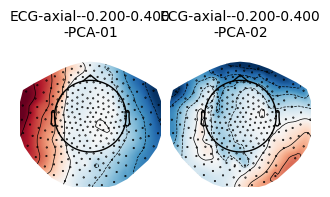

2 projection items deactivated
Using EOG channels: VEOG, HEOG
EOG channel index for this subject is: [298 299]
Filtering the data to remove DC offset to help distinguish blinks from saccades
Selecting channel VEOG for blink detection
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 2500 samples (10.000 s)

Now detecting blinks and generating corresponding events
Found 166 significant peaks
Number of EOG events detected: 166
Not setting metadata
166 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 2)
Using data from preloaded Raw for 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s


Not setting metadata
166 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 2)
2 projection items activated
Using data from preloaded Raw for 166 events and 101 original time points ...


[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.5s


0 bad epochs dropped
No channels 'grad' found. Skipping.
Adding projection: axial--0.200-0.200-PCA-01 (exp var=96.6%)
Adding projection: axial--0.200-0.200-PCA-02 (exp var=1.3%)
Adding projection: axial--0.200-0.200-PCA-03 (exp var=0.8%)
No channels 'eeg' found. Skipping.
Done.
Removing 5 compensators from info because not all compensation channels were picked.
Removing 5 compensators from info because not all compensation channels were picked.
Removing 5 compensators from info because not all compensation channels were picked.
Removing 5 compensators from info because not all compensation channels were picked.
Removing 5 compensators from info because not all compensation channels were picked.


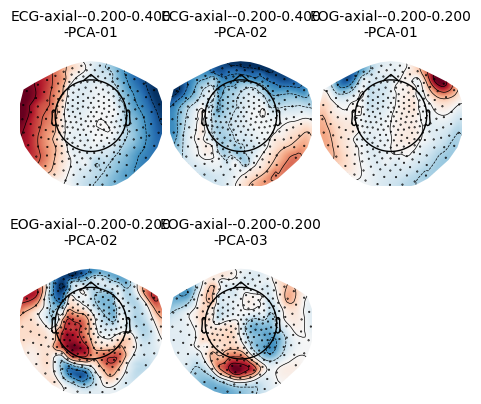

5 projection items deactivated
Created an SSP operator (subspace dimension = 5)
5 projection items activated
SSP projectors applied...


<RawCTF | sub-0002_ses-01_task-rest_run-01_meg.meg4, 300 x 150000 (600.0 s), ~343.8 MB, data loaded>

In [4]:
# Apply SSP projectors to remove ECG/EOG artifacts 
ecg_evoked = create_ecg_epochs(raw).average()
ecg_projs, ecg_events = compute_proj_ecg(raw,n_mag=2, reject=None)
mne.viz.plot_projs_topomap(ecg_projs, info=raw.info)
raw.add_proj(ecg_projs)

eog_evoked = create_eog_epochs(raw).average()
eog_projs, events = compute_proj_eog(raw, n_mag=3, reject=None)
mne.viz.plot_projs_topomap(eog_projs, info=raw.info)
raw.add_proj(eog_projs)

raw.apply_proj()

### 1. Set Number of States 

The only parameter that must be defned by the user for the microstates analysis is the number of states to detect. The typical number of states used broadly in the EEG literature is 4. Here, we are using 6 to match the number of patterns extracted by other multi-channel methods in this work.  Alternatively, algorithms can be used to select an optimal number of states for your research application. For example, see Tait & Zhang (2022; https://doi.org/10.1016/j.neuroimage.2022.119346)


In [5]:
# Define number of microstates
n_states = 6

### 2. Cluster Into Microstates 

By calling segment function in the mne_microstates toolbox, microstates are identified using k-means clustering, repeating over 10 iterations. The method outputs topographical maps of each identified microstate along with a segmentation of the signal showing the onsets and durations of each microstate. 

In [6]:
# Prep data 
raw.pick_types(meg=True, ref_meg=False)
dat = raw.get_data(picks=['meg'])

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Removing 5 compensators from info because not all compensation channels were picked.


In [7]:
# Clustering data into microstates
maps, seg = mne_microstates.segment(dat, n_states=n_states)

Finding 6 microstates, using 10 random intitializations
Converged at 85 iterations.
GEV of found microstates: 0.478205
Converged at 79 iterations.
GEV of found microstates: 0.479680
Converged at 51 iterations.
GEV of found microstates: 0.476664
Converged at 46 iterations.
GEV of found microstates: 0.478773
Converged at 61 iterations.
GEV of found microstates: 0.479691
Converged at 48 iterations.
GEV of found microstates: 0.480455
Converged at 39 iterations.
GEV of found microstates: 0.475195
Converged at 84 iterations.
GEV of found microstates: 0.477406
Converged at 89 iterations.
GEV of found microstates: 0.480036
Converged at 52 iterations.
GEV of found microstates: 0.479098


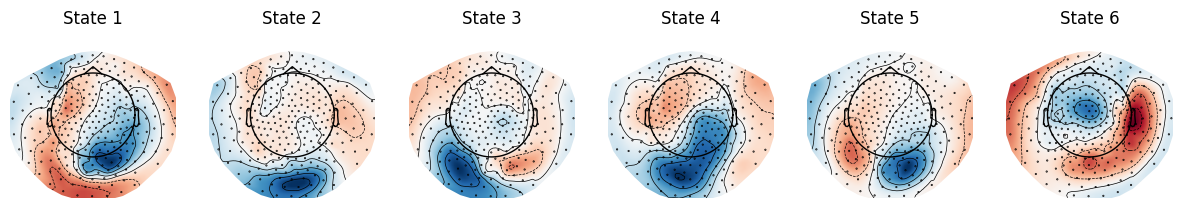

In [8]:
# Plotting microstate maps
fig, axes = plt.subplots(1, n_states, figsize=(15, 4))

for i, (ax, m) in enumerate(zip(axes.flatten(), maps)):
        mne.viz.plot_topomap(m, raw.info, 
                             cmap='RdBu',
                             axes=ax, show=False)
        ax.set_title('State %d' % (i+1))
plt.show()

In [11]:
# Get state information to plot power spectra for each
alp = [np.eye(n_states)[state] for state in seg]
    
# calculating WELCH state spectra & coherence
from osl_dynamics.analysis import spectral
f, psd, coh, w = spectral.welch_spectra(
    data= dat.T,
    alpha =  np.array(alp),
    sampling_frequency = Fs,
    frequency_range=[1,50],
    return_weights = True,
    n_jobs=1,
)

av_psd = np.mean(psd, axis=1)

2025-06-25 16:41:40 INFO osl-dynamics [spectral.py:244:welch_spectra]: Calculating spectra


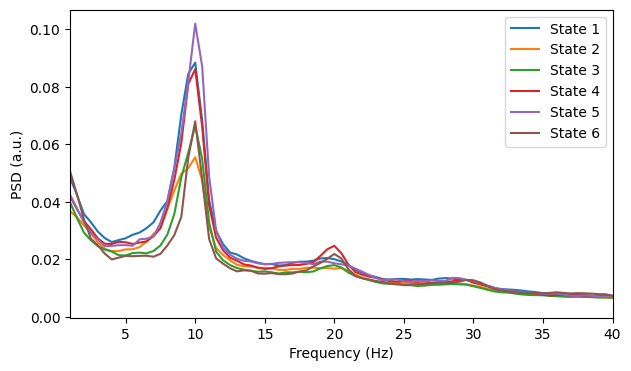

In [12]:
# Plot PSDs for each microstate
from osl_dynamics.utils import plotting

fig, ax = plotting.plot_line(
    [f] * n_states,
    av_psd,
    labels=[f"State {i}" for i in range(1, n_states + 1)],
    x_label="Frequency (Hz)",
    y_label="PSD (a.u.)",
    x_range=[1, 40]
)
plt.show()